# Imports

In [1]:
#General
import re
import os
import math
import random
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

#XML parsing
from xml.etree import ElementTree

#Model
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
#Testing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#NLTK
import nltk
from nltk import TweetTokenizer

# Functions 


In [2]:

################################## Global Values #############################################################
#--- init OneHotEncoders
ohe_FW = OneHotEncoder(sparse = True)

################################### General functions  #######################################################

def to_Matrix (X):
    return [X]


    # -----------------Re-sampling function ---------------#
    #Rob van der Goot, Ahmet ̈Ust ̈un, Alan Ramponi, andBarbara Plank. 2020a. MaChAmp proportional sam-pling. 
    # https://github.com/machamp-nlp/machamp/blob/master/machamp/   modules/bucket_batch_sampler.py

def sample_smoothing(dataframe, sampling_smoothing):

    distribution = dataframe.groupby(dataframe['Label']).count()['Text']
    labels = dataframe['Label'].unique().tolist()
    labels.sort()

    if sampling_smoothing != 1.0:
        all_batches = []
        df_sorted = dataframe.sort_values(by='Label')

        for label in labels:
            df_Batch = df_sorted[df_sorted['Label'] == label]
            batch = df_Batch.values.tolist()
            all_batches.append(batch)


        sizes = distribution.tolist()
        total_size = sum(sizes)

        # calculate new size based on smoothing
        new_sizes = []
        total_new_prob = 0.0
        for size in sizes:
            pi = size/total_size
            total_new_prob += math.pow(pi, sampling_smoothing)

        for size in sizes:
            pi = size/total_size
            prob = (1/pi) * (math.pow(pi, sampling_smoothing)/total_new_prob)
            new_sizes.append(int(size * prob))
        # print(new_sizes)

        # collect all batches
        this_epoch_all_batches = []
        for dataset_idx in range(len(sizes)):
            new_size = new_sizes[dataset_idx]
            while new_size > len(all_batches[dataset_idx]):
                all_batches[dataset_idx] += all_batches[dataset_idx]
            this_epoch_all_batches += all_batches[dataset_idx][:new_size]

        # shuffle all batches
        random.seed(1)
        random.shuffle(this_epoch_all_batches)
        # recreate dataframe
        return pd.DataFrame(this_epoch_all_batches, columns=['Text', 'Label'])

    else: 
        return dataframe


################################## for CountVectorizer #######################################################

#---Tokenizer for CountVectorizer
def custom_tokenizer(document):
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(document)
    return tokens

################################## for Custom Featurizers ####################################################

#Featurizer 1 
class FeaturizerFirstWord(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cont_Words = {"and","but", "or", "while","me", "also", "hence", "thus", "so", "because"}
        utt_List = X.tolist()
        fwList = []
        for utt in utt_List:
            if " " in utt:
                placeholder = utt.split(" ")[0].lower()
                if placeholder in cont_Words:
                    fwList.append(to_Matrix(1))
                else:
                    fwList.append(to_Matrix(0))
            else:
                if utt.lower() in cont_Words:
                    fwList.append(to_Matrix(1))
                else:
                    fwList.append(to_Matrix(0))
        return ohe_FW.fit_transform(fwList)

    def get_feature_names(self):
        return ohe_FW.categories_


## CSV "Parser" for ConvitKit Annotated Corpus

In [3]:
df_Reddit = pd.read_csv("../RedditConviKit/RedditCorpusAnnotated.csv")        
df_Reddit.dropna(axis=0, subset=['Label'], how='all', inplace=True)
df_Reddit

,id,timestamp,speaker,reply_to,conversation_id,meta.top_level_comment,meta.subreddit,utt_length,Text,MlviLabel,NikwLabel,Label
0,e631679,1537119633,MooMoo4228,9gb412,9gb412,e631679,todayilearned,127,Owen Wilson is usually known for comedies but ...,Statement,Statement,Statement
1,e632xlh,1537121043,poopiepuppy,e631679,9gb412,e631679,todayilearned,18,Such a great film!,Emphasis,Accept,Emphasis
2,e634v7o,1537122592,dr-cringe,e631679,9gb412,e631679,todayilearned,97,I saw him in Shanghai Noon before BEL. I could...,Statement,Emphasis,Emphasis
3,e635506,1537122816,belugabagel,e631679,9gb412,e631679,todayilearned,142,It's up there with Taken for me as a movie whe...,Statement,Statement,Statement
4,e635ue5,1537123387,SpaceJuke,e631679,9gb412,e631679,todayilearned,22,Also Midnight in Paris,Continuer,Statement,Continuer
...,...,...,...,...,...,...,...,...,...,...,...,...
995,e67r1vs,1537302212,Ralph-Hinkley,e67qipy,9gvc97,e6715gk,trees,85,DC has lots of shady places like that. Buy *so...,Statement,Statement,Statement
996,e67r6sh,1537302320,Ralph-Hinkley,e67p8d7,9gvc97,e6715gk,trees,150,Correct. Been decriminalized in Ohio for years...,Accept,Accept,Accept
997,e67rco0,1537302448,kgonzales90,e67r6sh,9gvc97,e6715gk,trees,102,Im in Texas and its decriminalized but it depe...,Statement,Statement,Statement
998,e67rrv5,1537302786,jackster_,e67qipy,9gvc97,e6715gk,trees,63,"My weed is free, it just comes in a very expen...",Statement,Statement,Statement


# Parsers
## XML Parser for NPSCHATCORPUS
Custom build XML parser, created for loading the NPSCHATCORPUS.

In [4]:
#Initialize Dataframe
df_NPSPre = pd.DataFrame(columns = ["Text", "Label"])

#XML Parser for NPSCHAT CORPUS
folder_path = "../npsChat/XML Files"
XML_files = os.listdir(folder_path)
for f in XML_files:
    file_name = "../npsChat/XML Files/" + f
    Tree = ElementTree.parse(file_name)
    session = Tree.getroot()
    for Posts in session:
        for post in Posts:
            Utt_Class = (post.attrib["class"])
            Utt_text = post.text
            new_Row = {"Text": Utt_text, "Label": Utt_Class}
            df_NPSPre = df_NPSPre.append(new_Row, ignore_index = True)

# Cross domain specific Pre-processing for SVM

In [5]:
# Re sampleling
df_NPS = sample_smoothing(df_NPSPre, 0.64)    #Change to any value between 1.0 and 0.00
df_NPS["Label"].value_counts()


System        2017
Statement     1888
Greet         1229
Emotion       1141
ynQuestion     761
whQuestion     707
Accept         472
Continuer      439
Bye            356
Reject         346
Emphasis       318
yAnswer        295
Clarify        236
nAnswer        219
Other          139
Name: Label, dtype: int64

# Model Setup

## Vectorization

In [6]:
X = df_NPS['Text']
y = df_NPS['Label']

reddit_vocab = df_Reddit['Text']
reddit_label = df_Reddit['Label']

reddit_dev, reddit_test, reddit_dev_label, reddit_test_Labels = train_test_split(reddit_vocab,reddit_label, train_size=0.50, test_size=0.50, random_state =101)

In [7]:


FU = FeatureUnion([
    ("TfidfVecWord",TfidfVectorizer(tokenizer=custom_tokenizer ,ngram_range=(1,1),binary = True)),
    ("TfidfVecChar",TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range=(2,3), binary = True, analyzer="char_wb")),
    ("VecFirstWord", FeaturizerFirstWord()),
])

FU.fit_transform(X)

X_vectorized = FU.transform(X)
reddit_vectorized = FU.transform(reddit_dev)
print(X_vectorized.shape)
print(reddit_vectorized.shape)


(10563, 13607)
(500, 13607)


## Support Vector Machine

Accuracy (RBF Kernel):  60.00
F1 (RBF Kernel):  54.66


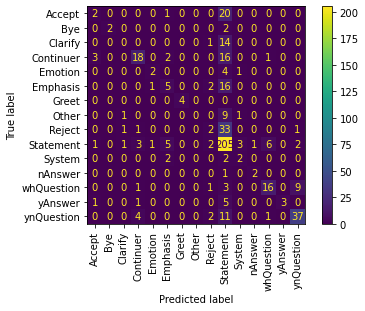

In [8]:
rbf_reddit = svm.SVC(kernel='rbf', gamma="scale", C=4).fit(X_vectorized, y)
rbf_reddit_pred = rbf_reddit.predict(reddit_vectorized)
rbf_reddit_accuracy = accuracy_score(reddit_dev_label, rbf_reddit_pred)
rbf_reddit_f1 = f1_score(reddit_dev_label, rbf_reddit_pred, average = 'weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_reddit_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_reddit_f1*100))
plot_confusion_matrix(rbf_reddit, reddit_vectorized, reddit_dev_label, xticks_rotation = 'vertical')  
plt.show()

